# 目的
ラベリングのミスを修正した後に訓練したモデルを用いてバックテストを行う。

# 前回保存したデータのテスト

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import os
import pickle
import pandas as pd
import numpy as np
import datetime

from FX.FX import SQLAnaforFX
from FX.FX import drawfigfunc as dff
from FX.FX import datetimefuncs as dtf
from FX.FX import analyzefuncs as af
from FX.FX import KerasModelAdapter
from FX.FX import backtest

Using TensorFlow backend.


In [2]:
adapter2 = KerasModelAdapter()
adapter2.load("./data/model_20170601_2/")

In [3]:
model = adapter2.model()

In [4]:
"""DBの読み込み"""
dbpath = "201704"
sql = SQLAnaforFX(dbpath)
sql.showtablenames()

"""OHLC"""
close = sql.toDataFrame("ask01min", colselect=["close"]).as_matrix()[:,0]
opens = sql.toDataFrame("ask01min", colselect=["open"]).as_matrix()[:,0]
high = sql.toDataFrame("ask01min", colselect=["high"]).as_matrix()[:,0]
low = sql.toDataFrame("ask01min", colselect=["low"]).as_matrix()[:,0]
ohlc = np.vstack((opens, high, low, close))
oc = np.vstack((opens, close)).T

dclose = np.zeros_like(close)
dclose[1:] = np.diff(close)

"""Spread"""
close_bid = sql.toDataFrame("bid01min", colselect=["close"]).as_matrix()[:,0]
s = np.mean((close - close_bid)[close != 0])
close_ask = close_bid + s
ask_bid = np.vstack((close_ask, close_bid)).T

"""SMA"""
sma = sql.toDataFrame("ask01min", colselect=["sma07", "sma13", "sma25"]).as_matrix()
sma = sma.T

## SMAを利用する場合、データの最初から数えてSMAの最大スパンまでのデータは利用しない方がよさそう。
sma_max_span = 25

"""Datetime"""
_ = sql.toDataFrame("ask01min", colselect=["sma07"])
dtformat = "%Y-%m-%d %H:%M:%S"
datetimes = list(_.index)
datetimes = [datetime.datetime.strptime(datetimes[ii], dtformat) for ii in range(len(datetimes))]
datetimes = np.array([(datetimes[ii] - datetimes[0]).total_seconds()/60.**2 for ii in range(len(datetimes))])

In [80]:
y, diff = af.labeling(close, 2*s, 30, 2)
y = y[sma_max_span:]

hlsma = np.vstack((high, low, sma))
hlsma_mean = hlsma[:, sma_max_span:].mean(axis=1)
hlsma_norm = np.zeros_like(hlsma[:, sma_max_span:])
for ii in range(hlsma.shape[0]):
    hlsma_norm[ii] = hlsma[ii, sma_max_span:] - hlsma_mean[ii]
    hlsma_norm[ii] /= np.abs(hlsma_norm[ii]).max()

X = hlsma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18622, 5) (7982, 5) (18622, 3) (7982, 3)


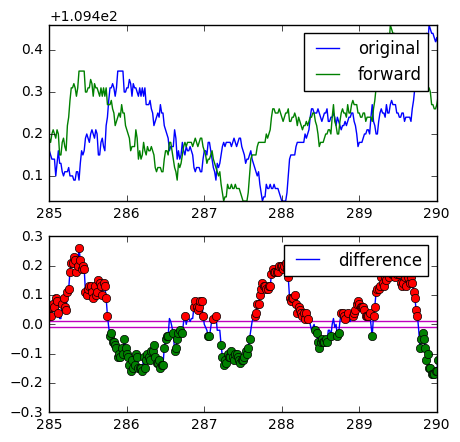

In [74]:
y, diff = af.labeling(close, 2*s, 30, 2)
xlim = [285, 290]

dff.makefig(5,5)
plt.subplot(211)
plt.plot(datetimes, close, label="original")

close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
plt.plot(datetimes, close_forward, label="forward")
ind = (datetimes>= xlim[0])&(datetimes <= xlim[1])
plt.xlim(xlim)
plt.ylim([close[ind].min(), close[ind].max()])
plt.legend()

plt.subplot(212)
plt.plot(datetimes, diff, label="difference")
plt.plot(datetimes[y[:, 0]== 1], diff[y[:, 0]== 1], "ro")
plt.plot(datetimes[y[:, 2]== 1], diff[y[:, 2]== 1], "go")
plt.hlines([-0.01, 0.01], datetimes[0], datetimes[-1], color="m")
plt.xlim(xlim)
plt.ylim(-0.3, 0.3)
plt.legend()

In [6]:
prob_threshold = 0.6
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [ 0  0 41] ,total: 41 , percentage:0.5
loss= 0.672707284369
accuracy= 0.878048783395


In [7]:
prob_threshold = 0.60
probs = model.predict_proba(X, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X[ind_sum], y[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [  0   0 113] ,total: 113 , percentage:0.4
loss= 0.550974136696
accuracy= 0.902654867257


# バックテスト
2017/05/30に作成されたモデルを用いてバックテストをやってみる。   
まずはそのエミュレートシステムを構築する。   
バックテストのシステムの要件を以下に挙げる。

* SQLDBに登録されたレコードを順に取得して予測にかける。
* モデルが「勝てる」と予測する確率を与え、それを超えたときに注文する。
* まずは注文してから $\tau$ 分後に決済する方針をとる。
    + 時間 $\tau$ はモデルの訓練に用いた時間差とする。
    + 損切りや途中決済は後々実装する。
* 決済するまでは新しい注文を出さない。
* スプレッドを与えられるようにする。
    + もしくは取得されたデータを用いてスプレッドを計算・更新する。
* スタートの値を与えられるようにする。

In [91]:
bt = backtest(model, ask_bid[sma_max_span:], hlsma_norm.T, 30, prob_threshold=0.50)

In [92]:
stop = len(close)
# stop = 3000
bt.run(stop)

In [93]:
len(datetimes[:stop-sma_max_span]), len(fund_history)

(26604, 26605)

In [96]:
fund_history[-1]

101449.99999999983

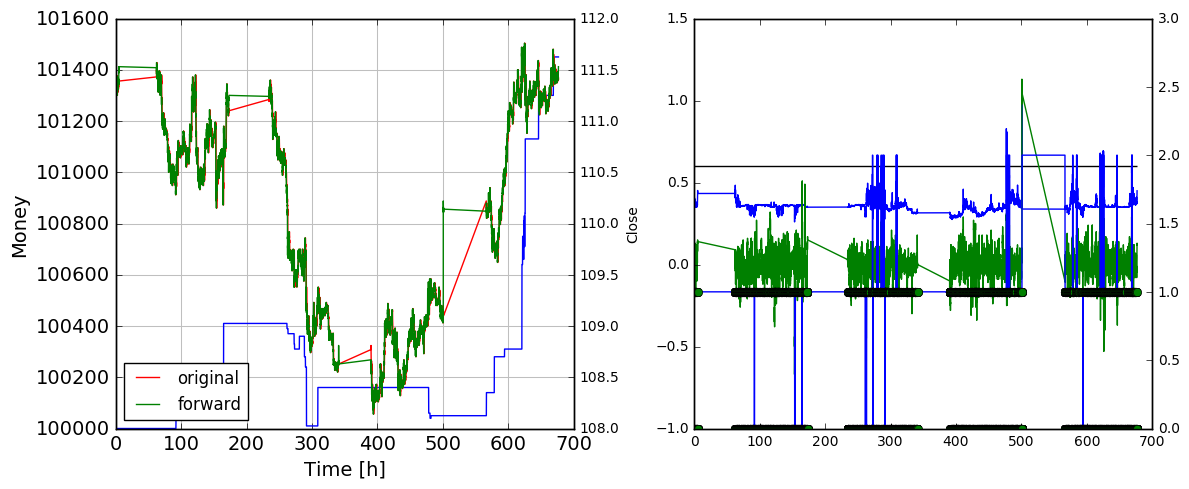

In [95]:
fund_history = bt.get_result().get("fund_history")
flags = bt.get_result().get("flag")
probs = model.predict_proba(hlsma_norm.T, verbose=0).T
short_prob = probs[2]

xlim = [0, 700]

dff.makefig(12,5)
plt.subplot(121)
plt.plot(datetimes[:stop-sma_max_span], fund_history[:-1])
dff.arrangefig(xlabel="Time [h]", ylabel="Money")
# plt.ylim(98500,100500)

ax2 = plt.gca().twinx()
plt.plot(datetimes[:stop-sma_max_span], close[:stop-sma_max_span], "r", label="original")
close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
close_forward[-30:] = close[-1]
plt.plot(datetimes[:stop-sma_max_span], close_forward[:stop-sma_max_span], "g", label="forward")
ax2.set_ylabel("Close")
plt.xlim(xlim)
plt.legend(loc=3)

plt.subplot(122)
# plt.hlines([0.60], datetimes[0], datetimes[-1])
plt.plot(datetimes[:stop-sma_max_span], short_prob)
plt.plot(datetimes[:stop-sma_max_span], (close_forward-close)[:stop-sma_max_span], "g")
plt.hlines([0.60], datetimes[0], datetimes[-1])
ax2 = plt.gca().twinx()
plt.plot(datetimes[:stop-sma_max_span], flags[:-1])
# plt.plot(datetimes[:stop-sma_max_span], y[:, 0], "ro")
plt.plot(datetimes[:stop-sma_max_span], y[:, 2], "go")
plt.xlim(xlim)
plt.ylim(0,3)

plt.tight_layout()

どうやら勝てるようである。

## 別の月のデータを用いてみる

In [97]:
"""DBの読み込み"""
dbpath = "201705"
sql = SQLAnaforFX(dbpath)
sql.showtablenames()

"""OHLC"""
close = sql.toDataFrame("ask01min", colselect=["close"]).as_matrix()[:,0]
opens = sql.toDataFrame("ask01min", colselect=["open"]).as_matrix()[:,0]
high = sql.toDataFrame("ask01min", colselect=["high"]).as_matrix()[:,0]
low = sql.toDataFrame("ask01min", colselect=["low"]).as_matrix()[:,0]
ohlc = np.vstack((opens, high, low, close))
oc = np.vstack((opens, close)).T

dclose = np.zeros_like(close)
dclose[1:] = np.diff(close)

"""Spread"""
close_bid = sql.toDataFrame("bid01min", colselect=["close"]).as_matrix()[:,0]
s = np.mean((close - close_bid)[close != 0])
close_ask = close_bid + s
ask_bid = np.vstack((close_ask, close_bid)).T

"""SMA"""
sma = sql.toDataFrame("ask01min", colselect=["sma07", "sma13", "sma25"]).as_matrix()
sma = sma.T

## SMAを利用する場合、データの最初から数えてSMAの最大スパンまでのデータは利用しない方がよさそう。
sma_max_span = 25

"""Datetime"""
_ = sql.toDataFrame("ask01min", colselect=["sma07"])
dtformat = "%Y-%m-%d %H:%M:%S"
datetimes = list(_.index)
datetimes = [datetime.datetime.strptime(datetimes[ii], dtformat) for ii in range(len(datetimes))]
datetimes = np.array([(datetimes[ii] - datetimes[0]).total_seconds()/60.**2 for ii in range(len(datetimes))])

In [103]:
y, diff = af.labeling(close, 2*s, 30, 2)
y = y[sma_max_span:]

hlsma = np.vstack((high, low, sma))
hlsma_mean = hlsma[:, sma_max_span:].mean(axis=1)
hlsma_norm = np.zeros_like(hlsma[:, sma_max_span:])
for ii in range(hlsma.shape[0]):
    hlsma_norm[ii] = hlsma[ii, sma_max_span:] - hlsma_mean[ii]
    hlsma_norm[ii] /= np.abs(hlsma_norm[ii]).max()

X = hlsma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19397, 5) (8314, 5) (19397, 3) (8314, 3)


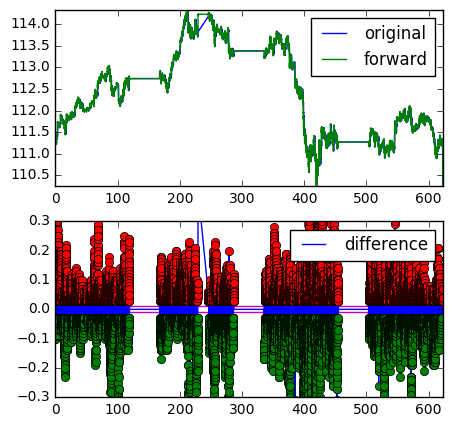

In [101]:
y, diff = af.labeling(close, 2*s, 30, 2)

xlim = [285, 290]
xlim = [datetimes[0], datetimes[-1]]

dff.makefig(5,5)
plt.subplot(211)
plt.plot(datetimes, close, label="original")

close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
plt.plot(datetimes, close_forward, label="forward")
ind = (datetimes>= xlim[0])&(datetimes <= xlim[1])
plt.xlim(xlim)
plt.ylim([close[ind].min(), close[ind].max()])
plt.legend()

plt.subplot(212)
plt.plot(datetimes, diff, label="difference")
plt.plot(datetimes[y[:, 0]== 1], diff[y[:, 0]== 1], "ro")
plt.plot(datetimes[y[:, 2]== 1], diff[y[:, 2]== 1], "go")
plt.hlines([-0.01, 0.01], datetimes[0], datetimes[-1], color="m")
plt.xlim(xlim)
plt.ylim(-0.3, 0.3)
plt.legend()

In [104]:
prob_threshold = 0.60
probs = model.predict_proba(X, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X[ind_sum], y[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [  0   0 825] ,total: 825 , percentage:3.0
loss= 1.37861788562
accuracy= 0.379393939484


In [107]:
bt = backtest(model, ask_bid[sma_max_span:], hlsma_norm.T, 30, prob_threshold=0.60)

100165.63924141899

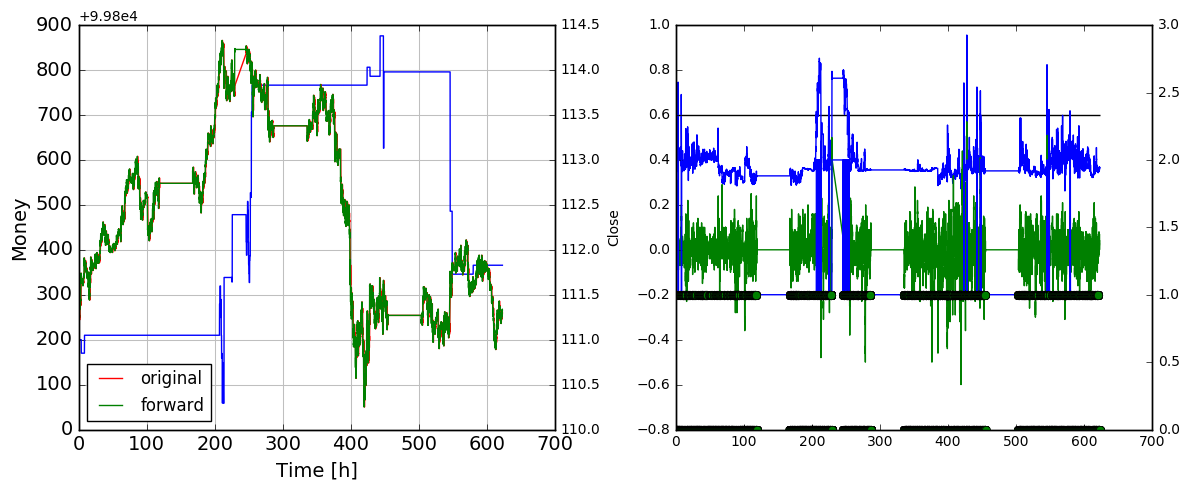

In [108]:
stop = len(close)
# stop = 3000
bt.run(stop)

fund_history = bt.get_result().get("fund_history")
flags = bt.get_result().get("flag")
probs = model.predict_proba(hlsma_norm.T, verbose=0).T
short_prob = probs[2]

xlim = [0, 700]

dff.makefig(12,5)
plt.subplot(121)
plt.plot(datetimes[:stop-sma_max_span], fund_history[:-1])
dff.arrangefig(xlabel="Time [h]", ylabel="Money")
# plt.ylim(98500,100500)

ax2 = plt.gca().twinx()
plt.plot(datetimes[:stop-sma_max_span], close[:stop-sma_max_span], "r", label="original")
close_forward = np.zeros_like(close)
close_forward[:-30] = close[30:]
close_forward[-30:] = close[-1]
plt.plot(datetimes[:stop-sma_max_span], close_forward[:stop-sma_max_span], "g", label="forward")
ax2.set_ylabel("Close")
plt.xlim(xlim)
plt.legend(loc=3)

plt.subplot(122)
# plt.hlines([0.60], datetimes[0], datetimes[-1])
plt.plot(datetimes[:stop-sma_max_span], short_prob)
plt.plot(datetimes[:stop-sma_max_span], (close_forward-close)[:stop-sma_max_span], "g")
plt.hlines([0.60], datetimes[0], datetimes[-1])
ax2 = plt.gca().twinx()
plt.plot(datetimes[:stop-sma_max_span], flags[:-1])
# plt.plot(datetimes[:stop-sma_max_span], y[:, 0], "ro")
plt.plot(datetimes[:stop-sma_max_span], y[:, 2], "go")
plt.xlim(xlim)
plt.ylim(0,3)

plt.tight_layout()
fund_history[-1]

やはり一筋縄ではいかないようである。月によって傾向が異なるという点と、欠損値も訓練に加えているという点が問題か？

# まとめ
４月のデータで学習したものは、４月においてはよく当たるようである。   
一方で５月のデータに対して用いると、どうも稼ぎが悪く、一筋縄ではいかないということが分かった。   
データを増やす必要があるという点と、休日をまたいだデータ作成をしないようにするという処理が必要か？   
他には30分ではなく15分で予測してみるとか、途中で切り上げるとか、いろいろあると思う。